"Correlation is not causation" goes the saying, cautioning against spurious correlation. Causally related phenomena, however, do correlate. How then can one differentiate spurious correlation from causal correlation, when confronted with a modeling problem? The following recommendations and simple simulation like the one making the subject of this post go a long way.

1. use causal DAGs - Directed Acyclic Graphs - to represent the current understanding of how the various pieces of data might be causally influencing each other (more on DAGs below.)
2. be aware of at least the four basic confounding mechanisms that lead to spurious correlation; namely, the Collider, the Pipe, the Fork, the Descendent.
3. be aware that spurious correlation through confounding can lead to <u>better</u> model performance that are ultimately misguiding and that can lead further inquiry astray.

<!-- TEASER_END -->
Here, I use a simple confounding-by-collider example to illustrate these points. The inspiration from this post comes from a tweet dated Jul 12, 2019, by Richard McElreath. 

First, import the required Python libraries...

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import seaborn as sb
from platform import python_version
from causalgraphicalmodels import CausalGraphicalModel as CGM


# PRINT PACKAGE VERSIONS FOR REPRODUCIBILITY
def print_version(pkg):
    print(f'{pkg.__name__} version: {pkg.__version__}')

print(f'Python version: {python_version()}')
for pkg in [np, pd, pm, az, sb]:
    print_version(pkg)

Python version: 3.7.3
numpy version: 1.16.2
pandas version: 0.24.2
pymc3 version: 3.7
arviz version: 0.4.1
seaborn version: 0.9.0


A statistical model will not care about the directionality of the causal relationships between the variables. Given $Y = f(X)$ and $X = g(Y)$ the link functions say nothing about which of these is the cause, which the effect. In a regression setting, it is easy to be seduced by the thought that the target variable is the effect and the predictor variable(s) the cause(s). 
<br><br>
Assuming three measurable phenomena, identified as $X$, $Y$, and $W$, for which the causal relationships are:

* $X$ influences $Y$
* both $X$ and $Y$ influence $W$

Note that causal relationships are probabilistic, meaning that a change in a causal phenomenon will alter the probability in which the effect manifests itself. Simplistically, this can be simulated as follows:

In [2]:
np.random.seed(42)
N = 1000
X = np.random.normal(size=N) # Gaussian centered at 0, with σ=1
Y = np.random.normal(loc=X, size=N) # Gaussian centered at X, with σ=1
W = np.random.normal(loc=X+Y, size=N) # Gaussian centered at X+Y with σ=1

This system's causal structure implied by the simulation above can be represented as follows:

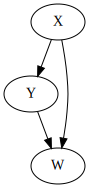

In [3]:
# instantiate the causal graph object...
cgm = CGM(nodes=['X', 'Y', 'W'], 
          edges=[('X', 'Y'), ('X', 'W'), ('Y', 'W')])
#... and plot the DAG
cgm.draw()

The graph above is a causal *Directed Acyclic Graph* or *DAG*, where nodes represent (ideally but not necessarily) measurable phenomena and edges represent directional causal link, with the parent node the cause, and the child node the effect. The rules in drawing DAGs are: *(1)* only unidirectional arrows are allowed (an effect cannot be a cause of its cause) and *(2)* loops are not allowed (an extension of the first rule to multiple nodes.)<br><br>

The researcher wants to predict $Y$ from whatever data is available using a linear model.
* (s)he collects data on $Y$, $X$ and $W$ without really understanding/simply ignoring causal relationships 
* (s)he proposes two models; $M1$ and $M2$ where:
    * M1: $Y\sim f(X)$
    * M2: $Y\sim f(X, W)$
* To avoid complications, $f$ represents linear relationships such that
    * M1: predicts Y from X only  $\Rightarrow\ Y \sim \beta X$
    * M2: predicts Y from both X and W $\Rightarrow\ Y \sim \beta X + \gamma W$

#### <u>NOTE THAT:</u>
* M1 is an UN-CONFOUNDED MODEL, where a correlation is a symptom of a real causal link.
* M2 is a CONFOUNDED MODEL, where correlation is spurious, and the suspected causal link is actually not there.

#### $\rightarrow$ Here's a quick illustration of the pairwise relationship for X,  Y, W.

In [4]:
df = pd.DataFrame(np.c_[X, Y, W], columns=['X', 'Y', 'W'])

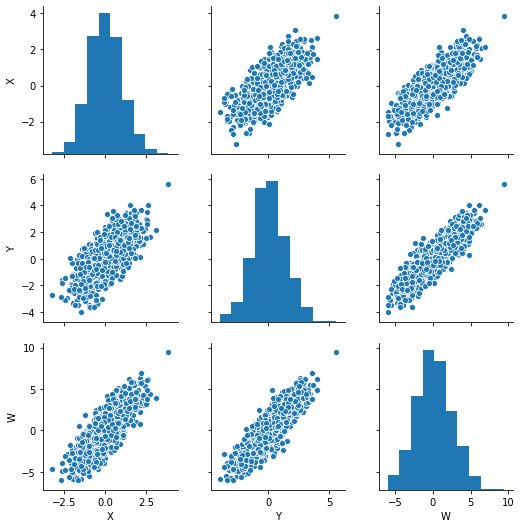

In [5]:
sb.pairplot(df);

The above does not offer any hint at what the causal relationships might be; unlike statistical inference, causal inference is not a reductionist exercise and requires some thinking, some DAG drawing, and  writing and fitting several models to tease out the correct underlying relationship. More on that in a later post.<br><br>
Below, I implement the first model $M1$, predicting $Y$ on $X$ only. I use a bayesian framework, the details of which are not important here. Suffice it to say that the goal is to get probability distributions for the values of model parameters,  $\beta$ in $M1$ and $\beta$ and $\gamma$ in $M2$, that measure the association between predictor(s) and target.

In [6]:
# unconfounded model
with pm.Model() as M1:
    β = pm.Normal('β', mu=0, sd=1)
    μ = β * X
    σ = pm.Exponential('σ', 1)
    Y_lik = pm.Normal('Y_lik', mu=μ, sd=σ, observed=Y)
    trace_1 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:02<00:00, 2213.15draws/s]


#### $\rightarrow$ Plotting the marginal posteriors of M1 parameters

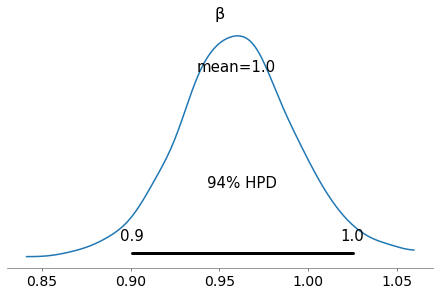

In [7]:
az.plot_posterior(trace_1, var_names=['β']);

Recall that Y was generated as a Gaussian centered on X, implying on average a  1-1 relationship. The plot above shows the model was able to recover this with $\beta$'s posterior mean equal to 1.0 

In [8]:
# confounded model
with pm.Model() as M2:
    β = pm.Normal('β', mu=0, sd=1)
    γ = pm.Normal('γ', mu=0, sd=1)
    μ = β * X + γ * W
    σ = pm.Exponential('σ', 1)
    Y_lik = pm.Normal('Y_lik', mu=μ, sd=σ, observed=Y)
    trace_2 = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, γ, β]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1686.65draws/s]


#### $\rightarrow$ Plot the marginal posteriors of M2 parameters

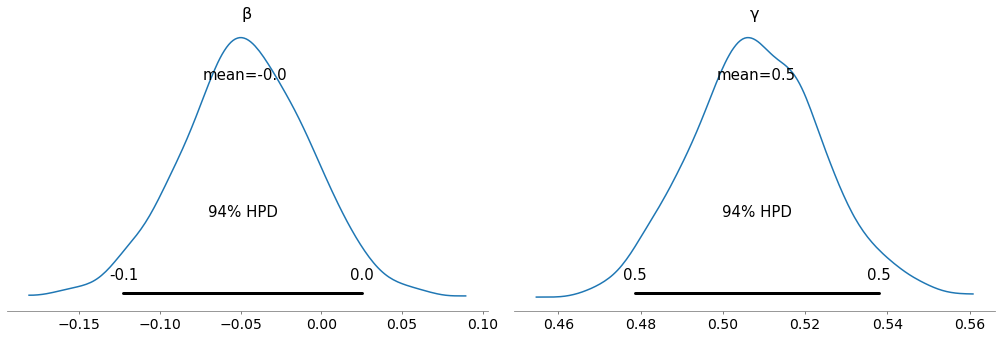

In [9]:
az.plot_posterior(trace_2, var_names=['β', 'γ']);

Conditioning on W has removed the association between X and Y $\rightarrow$ notice how the posterior of the $\beta$ parameter, which multiplies X  in both M1 and M2, is practically centered on '0', indicating an absence of significant relationship between X and Y in M2.

Typically, ranking predictive skill of Bayesian models is done by comparing each model's WAIC (Watanabe-Akaike Information Criterion) score, where a lower score corresponds to an expectation of better prediction of model data (More on model comparison/selection at a later time.)

In [10]:
az.compare({'M2': trace_2, 'M1': trace_1})

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
M2,2141.9,3.0834,0,1,45.3117,0,False,deviance
M1,2839.39,2.04868,697.49,6.02443e-121,45.3691,45.5681,False,deviance


The table above shows M2 is the model expected to do overwhelmingly (according to the weight column) better at predicting future (out of sample) data. This illustrates the difference between the predictive skill of the model and its accurate portrayal of true causal relationships, at least in the short run. However model debugging can rapidly become a problem if the causal structure that the researcher is actually trying to get at, assuming (s)he wants to understand what is actually going on, is mischaracterized. This can lead research astray with continued reliance on a misunderstood paradigm. 

Hopefully, I was able to convey that a good way to avoid this fate is to attack any modeling project, pen and paper in hand, and draw one ore more $Causal \ Graphs$ and avoid the malevolent causal salad.
<br><br>
Here's a [fun blogpost](https://blog.fastforwardlabs.com/2019/02/28/causality-in-machine-learning.html) discussing the place of causal inference in machine learning].
<br><br>
Happy coding!